In [2]:
#Quantum Neural Network for MNIST Classification (0 vs 1)
# All the imports that would be needed for the code to run!
# Import PennyLane (Quantum library) and its NumPy version
import pennylane as qml
from pennylane import numpy as np
# Import PyTorch for machine learning utilities
import torch 
import torchvision 
from torchvision import transforms 
from torch.utils.data import DataLoader, Subset
#-----------------------------


In [3]:
# ----------------------------
# Data Loading and Preprocessing
# ----------------------------
#Load MNIST and reduce to digits 0 and 1
#Define a transformation: convert images to tensors and normalize pixel values to [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
#-----------------------------

In [4]:
#Filter digits 0 and 1 only
# Create a function to filter the dataset
# This function filters the dataset to keep only samples with labels 0 or 1
def filter_digits(dataset):
    idx = (dataset.targets ==0) | (dataset.targets ==1)
    # Keep samples where label is 0 or 1
    dataset.targets = dataset.targets[idx]
    return dataset
train_data = filter_digits(train_data)
test_data = filter_digits(test_data)
#----------------------------

In [5]:
#Downsample images to 4x4 = 16 pixels (for 4 qubits)
#(Since using 4 qubits, each qubit gets 1 feature)
#Downsample function to reduce the image size
def downsample(img):
    img = img.unsqueeze(0).unsqueeze(0).float()# (1, 1, 28, 28)
    downsampled = torch.nn.functional.interpolate(#Downsample the image
        img, 
        size=(4, 4),
        mode='bilinear',
        align_corners=False
    )
    return downsampled.squeeze()  # back to (4, 4)


# Create a custom dataset to prepare quantum-friendly input
class QuantumMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        # Save data as a list of (image, label) pairs after filtering
        self.data = [(img, label) for img, label in zip(dataset.data, dataset.targets)]
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img, label = self.data[idx]
        features = downsample(img).numpy().flatten()[:4] # 4 features for 4 qubits
        features = features / np.linalg.norm(features)#Normalize feature vector
        return features, label
batch_size = 10 # giving a batch size of 10

#Create data loaders for training and testing
train_loader = DataLoader(QuantumMNISTDataset(train_data), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(QuantumMNISTDataset(test_data), batch_size=batch_size)

#-----------------------------

In [6]:
# ----------------------------
# Quantum Circuit Definition
# ----------------------------
# This is the quantum circuit that will be used for classification
# Set the number of qubits
n_qubits = 4 #Setting the number of qubits
# Initialize a quantum device (simulator)
dev = qml.device("default.qubit", wires=n_qubits)
# Encode classical input into quantum states using rotations
def angle_embedding(x):
    for i in range(n_qubits):
        qml.RY(x[i],wires=i) #Apply rotation around Y-axis
#Variational quantum layer (parameterized by weights)
def variational_block(weights):
    for i in range(n_qubits):
        qml.Rot(*weights[i], wires=i)  # Apply rotation with 3 parameters (X, Y, Z)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])      # Add entanglement between neighboring qubits
# Define the full quantum node (circuit + measurements)
@qml.qnode(dev, interface="torch") #This is a quantum node
def quantum_net(inputs,weights):
    angle_embedding(inputs) #Embed features into quantum state
    variational_block(weights) #Apply learnable quantum layer
    return qml.expval(qml.PauliZ(0)) # Measure expectation value of PauliZ on first qubit
# ----------------------------

In [7]:
# ----------------------------
# Defining the Full Quantum Neural Network in PyTorch
# ----------------------------
#Define the quantum neural network (QNN) class
#This class inherits from torch.nn.Module
#This class is a PyTorch module
class QNet(torch.nn.Module): #This is a PyTorch module
    def __init__(self): #Initialize the module with parameters
        super().__init__()# Call the parent constructor
        #Initialize the weights for the quantum circuit
        #The weights are the parameters of the quantum circuit
        weight_shapes = (n_qubits, 3)  # 3 parameters (angles) per qubit
        self.q_params = torch.nn.Parameter(torch.randn(weight_shapes) * 0.01) 
         #self.q_params is a learnable parameter
    def forward(self, x): #Forward pass through the quantum circuit
       #Apply quantum_net to each input separately and stack results
       return torch.stack(
            [quantum_net(x[i], self.q_params) 
            for i in range(x.shape[0])]
        ) 
    #Stack the outputs of the quantum circuit


In [8]:
# ----------------------------
# Model Training
# ----------------------------
#Defining the model, loss function, and optimizer
#Instantiate the model
model = QNet()
#Set up optimizer (Adam) and loss function (binary classification loss)
optimizer = torch.optim.Adam(model.parameters(),lr=0.1)
#Learning rate is set to 0.1
loss_fn = torch.nn.BCEWithLogitsLoss() #Binary Cross-Entropy with logits
#Number of epochs for training
epochs = 5
#Training loop
loss_history = []  # List to store loss values for each epoch

for epoch in range(epochs):
    for x_batch, y_batch in train_loader:
        y_batch = y_batch.float() #Convert labels to float
        preds = model(x_batch) #Get predictions from the model
        loss = loss_fn(preds.squeeze(), y_batch) #Calculate loss
        optimizer.zero_grad() #reset gradients 
        loss.backward() #Backpropagation
        optimizer.step() #Update parameters
    loss_history.append(loss.item())  # Store the loss for the current epoch
    print(f"Epoch {epoch+1}, Loss= {loss.item():.4f}") #Print loss for each epoch
#-----------------------------


/var/folders/zl/nb5s67cs451bsnbcgpz9fsgc0000gn/T/ipykernel_7466/2418914208.py:25: RuntimeWarning: invalid value encountered in divide
  features = features / np.linalg.norm(features)#Normalize feature vector


Epoch 1, Loss= nan
Epoch 2, Loss= nan
Epoch 3, Loss= nan
Epoch 4, Loss= nan
Epoch 5, Loss= nan


In [9]:
# ----------------------------
# Model Evaluation (Testing)
# ----------------------------

correct = 0
total = 0
# Disable gradient calculations for testing
with torch.no_grad(): # Disable gradient calculations
    for x_batch, y_batch in test_loader: #Iterate over test data
        outputs = model(x_batch).squeeze() #Get model outputs 
        # Apply sigmoid activation function to outputs
        # Convert outputs to binary predictions (0 or 1)
        predicted = (torch.sigmoid(outputs) > 0.5).int()  
        # Apply sigmoid then threshold at 0.5 
        correct += (predicted == y_batch).sum().item()   
        # Count correct predictions
        total += y_batch.size(0)    # Total number of samples
#Print final accuracy 
print(f"Test Accuracy: {correct/total:.2%}")


/var/folders/zl/nb5s67cs451bsnbcgpz9fsgc0000gn/T/ipykernel_7466/2418914208.py:25: RuntimeWarning: invalid value encountered in divide
  features = features / np.linalg.norm(features)#Normalize feature vector


Test Accuracy: 46.34%


/var/folders/zl/nb5s67cs451bsnbcgpz9fsgc0000gn/T/ipykernel_7466/2418914208.py:25: RuntimeWarning: invalid value encountered in divide
  features = features / np.linalg.norm(features)#Normalize feature vector


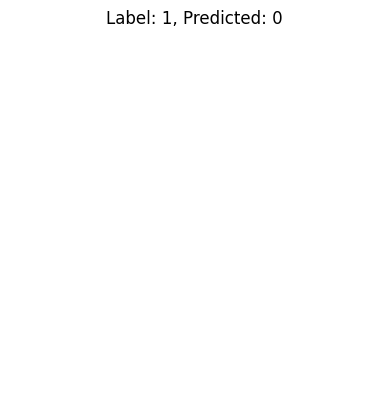

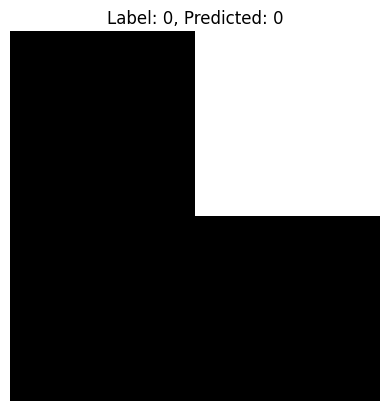

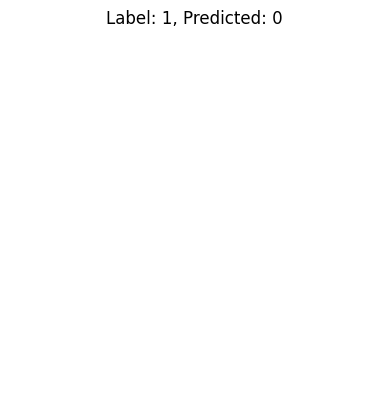

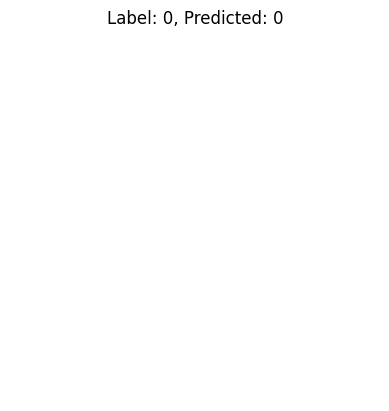

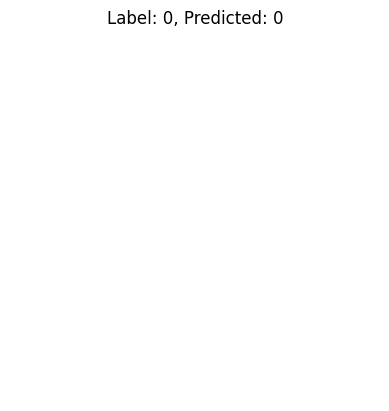

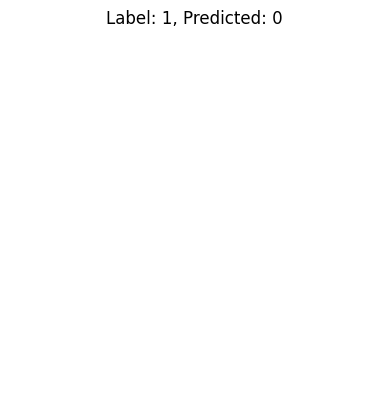

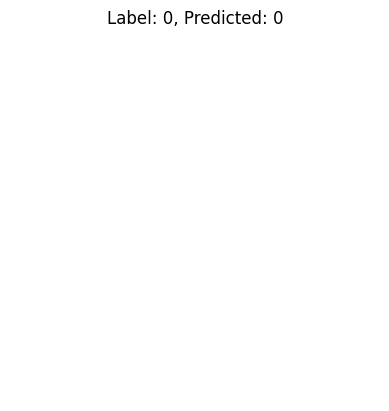

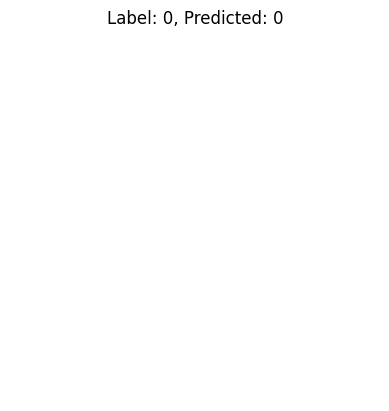

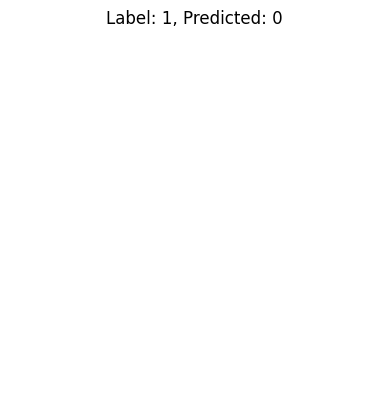

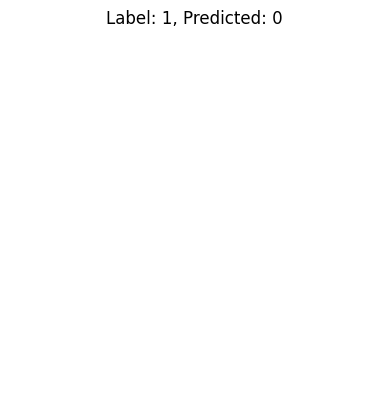

In [11]:
import matplotlib.pyplot as plt

# Show a few test samples with predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation for testing
    for x_batch, y_batch in test_loader:
        outputs = model(x_batch).squeeze()  # Get predictions
        preds = (torch.sigmoid(outputs) > 0.5).int()  # Apply sigmoid and threshold

        for i in range(len(x_batch)):
            img = x_batch[i].numpy()  # Get the features (already 4 elements)
            
            # Visualize the image as a 2x2 grid
            img_2d = img.reshape(2, 2)  # Reshape to a 2x2 grid

            plt.imshow(img_2d, cmap='gray')  # Plot as grayscale
            plt.title(f"Label: {int(y_batch[i])}, Predicted: {int(preds[i])}")
            plt.axis('off')  # Remove axes for clarity
            plt.show()
        
        break  # Show only the first batch (for visualization)


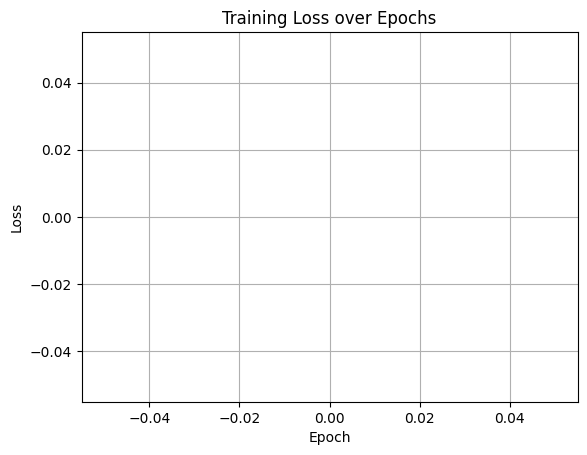

In [12]:
import matplotlib.pyplot as plt

# Plot training loss over epochs
plt.plot(range(1, epochs + 1), loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.show()
